In [1]:
from copy import deepcopy

import torch
import pytorch_lightning as pl
import numpy as np
import pandas as pd

from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf

from ens_transformer.data_module import IFSERADataModule

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as mpl_gs
import matplotlib.colors as mpl_c

In [2]:
plt.style.use('paper')
plt.style.use('egu_journals')
plt.rcParams['text.usetex'] = False

In [3]:
pl.seed_everything(42)

Global seed set to 42


42

In [4]:
with initialize(config_path="../data/models/transformer_scale/transformer_5_20/hydra"):
    cfg = compose('config.yaml')

In [5]:
ens_net = instantiate(
    cfg.model,
    in_channels=len(cfg.data.include_vars),
    learning_rate=cfg.learning_rate
)
ens_net = ens_net.load_from_checkpoint("../data/models/transformer_scale/transformer_5_20/last.ckpt", map_location=torch.device('cpu'))

In [6]:
data_module = instantiate(cfg['data']['data_module'], pin_memory=False)
data_module.setup()

In [7]:
dates = pd.to_datetime(('2019-09-01 12:00'))
ifs_data = data_module.ds_test.ifs.sel(time=dates)
era_data = data_module.ds_test.era5.sel(time=dates)
ifs_err = ifs_data.sel(var_name='t2m').mean('ensemble')-273.15-era_data

In [8]:
input_data = data_module.ds_test.input_transform(ifs_data.values[None, :])

In [9]:
attentions = []
with torch.no_grad():
    curr_tensor = ens_net.embedding(input_data)
    for transformer in ens_net.transformers:
        _, key_output, query_output = transformer._apply_layers(curr_tensor)
        curr_tensor = transformer(curr_tensor)
        curr_attention = (key_output.mean(dim=1) * query_output.mean(dim=1)).squeeze()
        attentions.append(curr_attention)

# Plot features maps

## Positions
Hurricane Dorian (20, 50)


In [10]:
normalized_attention = [
    (atten_map-atten_map.mean(dim=(-2, -1), keepdim=True))/atten_map.std(dim=(-2, -1), keepdim=True)
    for atten_map in attentions
]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


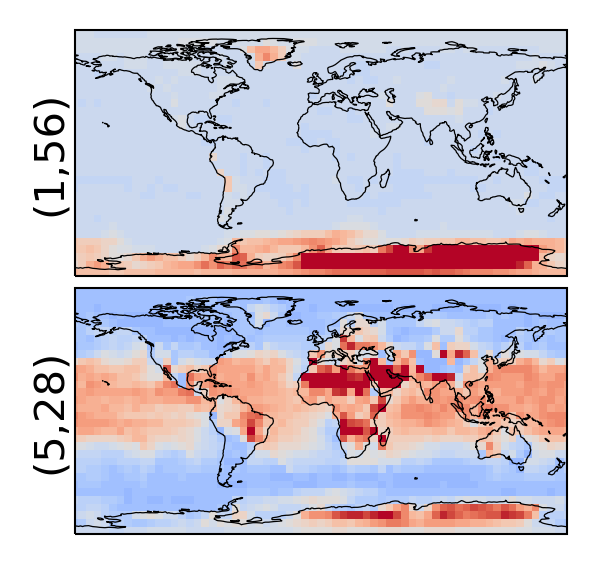

In [11]:
cmap = plt.get_cmap('coolwarm')
norm = mpl_c.BoundaryNorm(np.linspace(-2.5, 2.5, 41), cmap.N)

gs = mpl_gs.GridSpec(nrows=2, ncols=1)

figsize = [s*0.48 for s in plt.rcParams['figure.figsize']]

fig = plt.figure(figsize=figsize, dpi=300)

ax_feat_0 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
feat_plt, lons = add_cyclic_point(normalized_attention[0][56].numpy(), coord=data_module.ds_train.dataset.ifs['longitude'])
ax_feat_0.pcolormesh(lons, data_module.ds_train.dataset.ifs['latitude'], feat_plt, cmap=cmap, norm=norm)
ax_feat_0.text(-0.05, 0.5, '(1,56)', fontsize=10, va='center', ha='center',
               rotation='vertical', transform=ax_feat_0.transAxes)
ax_feat_0.coastlines(linewidth=0.3)

ax_feat_1 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())
feat_plt, lons = add_cyclic_point(normalized_attention[4][28], coord=data_module.ds_train.dataset.ifs['longitude'])
ax_feat_1.pcolormesh(lons, data_module.ds_train.dataset.ifs['latitude'], feat_plt, cmap=cmap, norm=norm)
ax_feat_1.text(-0.01, 0.5, '(5,28)', fontsize=10, va='center', ha='right',
               rotation='vertical', transform=ax_feat_1.transAxes)
ax_feat_1.coastlines(linewidth=0.3)
fig.savefig('../paper/figures/fig_attention.png', dpi=300, bbox_inches='tight')